In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

print(engine)

Engine(sqlite:///Resources/hawaii.sqlite)


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

print(Base)

<class 'sqlalchemy.ext.automap.Base'>


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

In [9]:
# View measurement columns in table.
Base.classes.measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [10]:
# View station columns in table.
Base.classes.station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [11]:
# Find the most recent date in the data set.

most_recent_date = session.query(func.max(Measurement.date)).first()

print(most_recent_date)

('2017-08-23',)


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate year, month, and day of the most recent date
yymmdd = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

print(yymmdd)


# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).limit(15).all()

2017-08-23 00:00:00


[('2010-01-01', 0.08),
 ('2010-01-02', 0.0),
 ('2010-01-03', 0.0),
 ('2010-01-04', 0.0),
 ('2010-01-06', None),
 ('2010-01-07', 0.06),
 ('2010-01-08', 0.0),
 ('2010-01-09', 0.0),
 ('2010-01-10', 0.0),
 ('2010-01-11', 0.01),
 ('2010-01-12', 0.0),
 ('2010-01-14', 0.0),
 ('2010-01-15', 0.0),
 ('2010-01-16', 0.0),
 ('2010-01-17', 0.0)]

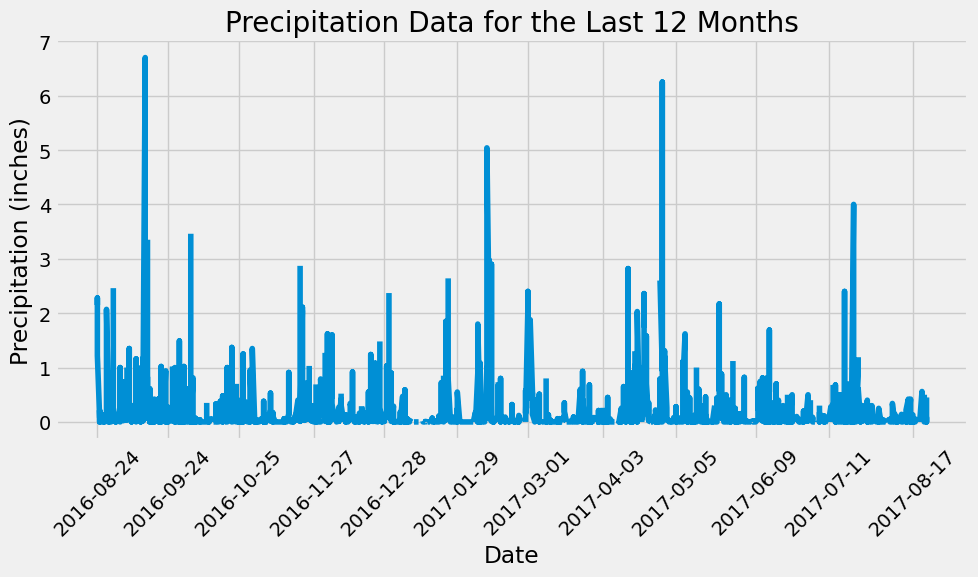

In [13]:

# Find the most recent date in the dataset
latest_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()

# Load the query results into a Pandas DataFrame
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data for the Last 12 Months')
n = 200  # Display every nth date
plt.xticks(df['Date'][::n], rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).group_by(Station.station).count()

print(total_stations)


9


In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Fetch all results
active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()

# Sort results in descending order based on the count (second element in the tuple)
sorted_station = sorted(active_station, key=lambda x: x[1], reverse=True)

for row in sorted_station:
  print(row)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_info = session.query(func.min(Measurement.tobs),
                        func.max(Measurement.tobs),
                        func.avg(Measurement.tobs)) \
                .filter(Measurement.station == 'USC00519281') \
                .all()

print(temp_info)

[(54.0, 85.0, 71.66378066378067)]


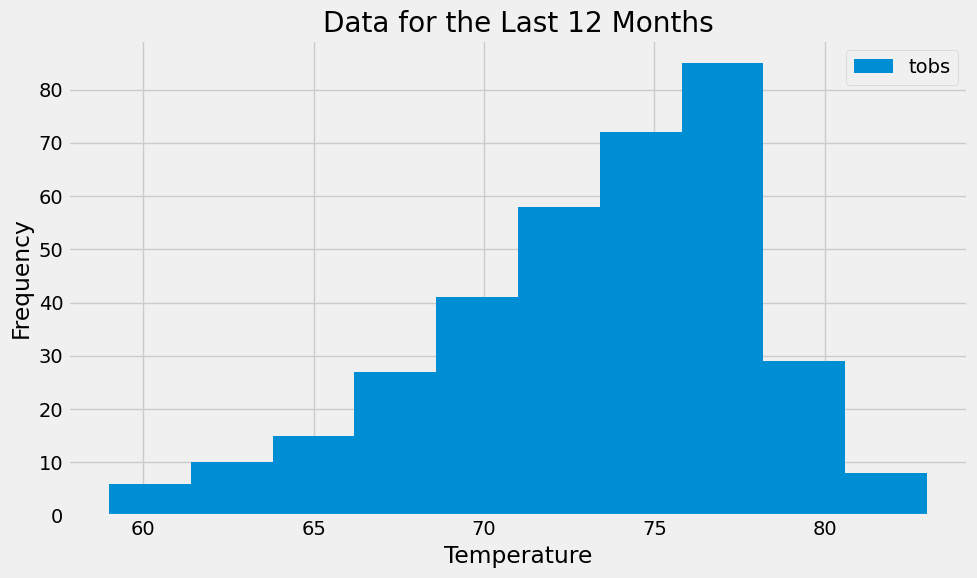

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = session.query((Measurement.tobs))\
    .filter(Measurement.date >= one_year_ago)\
    .filter(Measurement.station == 'USC00519281').all()

# Load the query results into a Pandas DataFrame
most_active_df = pd.DataFrame(most_active_station, columns=['tobs'])

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.hist(most_active_df, label=["tobs"]) 
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Data for the Last 12 Months')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()